In [13]:
import cv2

import matplotlib
from matplotlib import pyplot as plt

import numpy as np

from random import randint

import skimage.transform

import sklearn.datasets

import sys


## Loading


In [14]:
def load_images(asl_classes, count, size):
    img_list = []
    for class_name in asl_classes:
        for i in range(count):
            img_path_string = 'asl_alphabet/'+class_name+'/'+class_name+str(i+1)+'.jpg'
            img = cv2.imread(img_path_string) # opens image using CV2
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts image to grayscale
            img = skimage.transform.resize(img, (size, size), mode='constant') # resizes image
            img = np.array(img*256, dtype=np.uint8) # Converts image to a numpy array made up of uint8
            img = (img/255.0) - 0.5 # Normalizes image
#             img = img.flatten() # Linearize Images
            img_list.append(img)
        sys.stderr.write('\rClass %s done' % class_name)
        sys.stderr.flush()
    return img_list

In [15]:
%%time

number_of_images = 100

img_size = 32

asl_classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 
               'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 
               'del', 'space', 'nothing'
]

class_list = load_images(asl_classes, number_of_images, img_size)

Class nothing done

CPU times: user 4.46 s, sys: 306 ms, total: 4.77 s
Wall time: 4.75 s


In [16]:
class_titles = []
for i in range(len(asl_classes)):
    for j in range(number_of_images):
        class_titles.append(asl_classes[i])
        
class_values = []
for i in range(len(class_titles)):
    class_values.append(asl_classes.index(class_titles[i]))

In [17]:
# Functions
def shuffle(data, target):
    return data, target

def split(data, target, class_count, percentage):
    """Splits data and target into training and testing data based off the split percentage"""

    X_train = []
    y_train = []
    X_test = []
    y_test = []
    class_size = int(len(class_list) / class_count)
    
    for i in range(class_count):
        start = i * class_size
        index_split = start + int(percentage * class_size)
        end = (i * class_size) + class_size
        
        X_train.extend(data[start:index_split])
        X_test.extend(data[index_split:end])
        
        y_train.extend(target[start:index_split])
        y_test.extend(target[index_split:end])
        
    return X_train, X_test, y_train, y_test



# Shuffle Data
class_list, class_values = shuffle(class_list, class_values)

# Split Data
percentage = 10/11
class_list_train, class_list_test, class_values_train, class_values_test = split(class_list, class_values, len(asl_classes), percentage)

# Create sklearn Bunch Object
ds = sklearn.datasets.base.Bunch(
    X_train = np.array(class_list_train),
    y_train = np.array(class_values_train),
    X_test = np.array(class_list_test),
    y_test = np.array(class_values_test),
    y_names = np.array(asl_classes),
    img_size = img_size
)

# Print dimensions of object
print('Shape of X_train:', ds.X_train.shape)
print('Shape of y_train:', ds.y_train.shape)
print('Shape of X_test:', ds.X_test.shape)
print('Shape of y_test:', ds.y_test.shape)
print('Length/Width of images:', ds.img_size)

Shape of X_train: (2610, 32, 32)
Shape of y_train: (2610,)
Shape of X_test: (290, 32, 32)
Shape of y_test: (290,)
Length/Width of images: 32


In [18]:
del class_list
del class_list_train
del class_list_test
del class_titles
del class_values
del class_values_train
del class_values_test
del asl_classes
del img_size

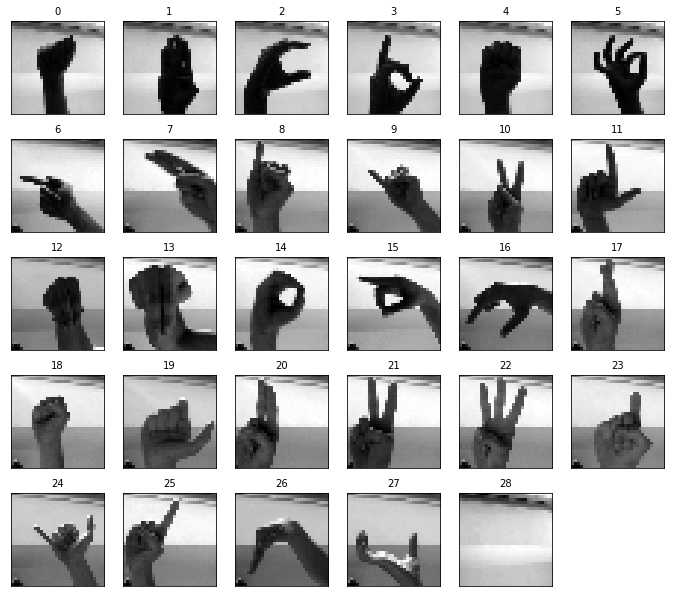

In [19]:
# a similar plotting function as seen in class; selects images from dataset
def plot_gallery(images, titles, img_size, random=False, n_row=5, n_col=6):
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.9, top=.70, hspace=.1)
    for i in range(n_row * n_col):
        if i != (n_row * n_col - 1):
            plt.subplot(n_row, n_col, i + 1)
            if random:
                index = randint(1, len(images)-1)
            else:
                index =int(i * len(images) / 29)
            plt.imshow(images[index], cmap=plt.cm.gray)
            plt.title(titles[index], size=10)
            plt.xticks(())
            plt.yticks(())

        
plot_gallery(images=ds.X_train, titles=ds.y_train, img_size=ds.img_size) 

# Larson's Code

In [20]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.layers import average 
from keras.models import Input, Model

keras.__version__

'2.2.4'

In [21]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
from skimage.io import imshow
import seaborn as sns
%matplotlib inline

def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,10))
    yhat = np.argmax(net.predict(X_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title(title_text+'{:.4f}'.format(acc))
    
        

In [22]:
# more data for handwriting recognition?
# Let's use Raschka's implementation for using the mnist dataset:
# https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# import os
# import struct
# import numpy as np

NUM_CLASSES = len(ds.y_names)

# NEW: Let's start by fixing the sizes
X_train = np.expand_dims(ds.X_train, axis=3)
X_test = np.expand_dims(ds.X_test, axis=3)
# the image data has been resized to (samples,image_rows,image_cols,image_channels)

# and one hot encoding the output values
y_train_ohe = keras.utils.to_categorical(ds.y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(ds.y_test, NUM_CLASSES)

print('New Shape: Rows: %d, image size: (%d,%d,%d)' % (X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3] ))

New Shape: Rows: 2610, image size: (32,32,1)


(2610, 32, 32, 1)


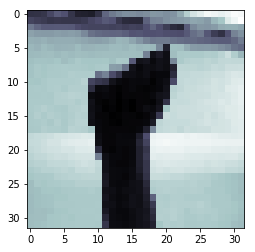

In [23]:
print(X_train.shape)
plt.subplot(1,1,1)
plt.imshow(X_train[1].squeeze(),cmap='bone')
plt.show()

## Starting simple
Let's first start by using data expansion on the Fashion MNIST dataset.

In [24]:
datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None)

datagen.fit(X_train)

# idx = 0

/Users/WillLacey/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/Users/WillLacey/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")
/Users/WillLacey/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")
/Users/WillLacey/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


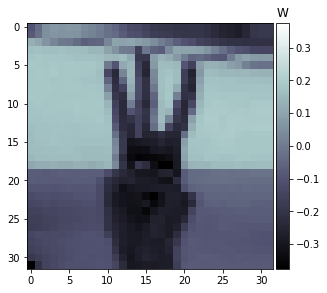

In [13]:
tmps = datagen.flow(X_train, y_train_ohe, batch_size=1)

for tmp in tmps:
    imshow(tmp[0].squeeze(),cmap='bone')
    plt.title(ds.y_names[np.argmax(tmp[1])])
    break

In [27]:
batch_size = 32
epochs = 15

In [25]:
%%time 

cnn = Sequential()

# let's start with an AlexNet style convolutional phase
cnn.add(Conv2D(filters=32,
                input_shape = (ds.img_size,ds.img_size,1),
                kernel_size=(3,3), 
                padding='same', 
                activation='relu', data_format="channels_last")) # more compact syntax

# no max pool before next conv layer!!
cnn.add(Conv2D(filters=64,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
    

# add one layer on flattened output
cnn.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn.add(Dense(NUM_CLASSES, activation='softmax'))

# Let's train the model 
cnn.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

# the flow method yields batches of images indefinitely, with the given transformations
cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=batch_size), 
                   steps_per_epoch=int(len(X_train)/batch_size), # how many generators to go through per epoch
                   epochs=epochs, verbose=0,
                   validation_data=(X_test,y_test_ohe)
                  )


CPU times: user 7min 54s, sys: 1min 46s, total: 9min 40s
Wall time: 1min 41s


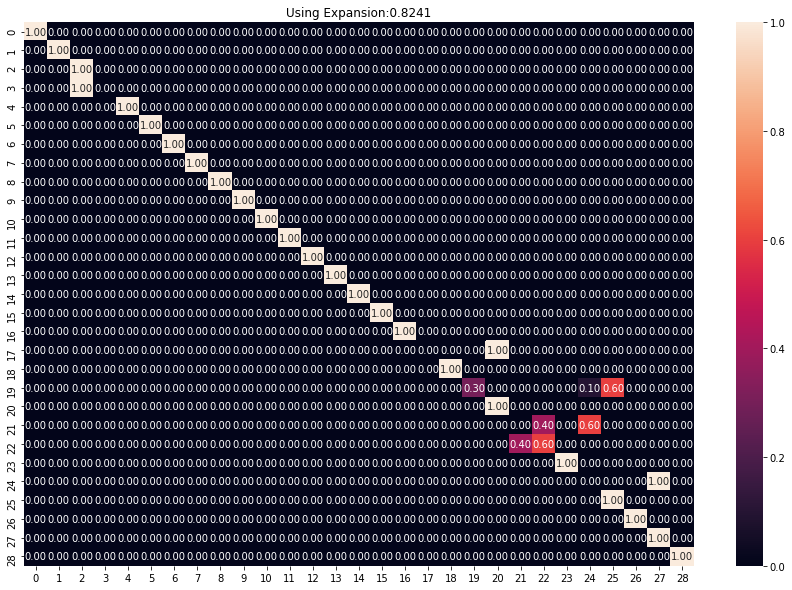

In [26]:
summarize_net(cnn, X_test, ds.y_test, title_text='Using Expansion:')

In [29]:
# what if we just want to use the validation data??
from keras.callbacks import EarlyStopping
from keras.regularizers import l2 
l2_lambda = 0.0001

# Use Kaiming He to regularize ReLU layers: https://arxiv.org/pdf/1502.01852.pdf
# Use Glorot/Bengio for linear/sigmoid/softmax: http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf 
cnn = Sequential()

cnn.add(Conv2D(filters=32,
               input_shape = (ds.img_size,ds.img_size,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu',
               data_format="channels_last")) # more compact syntax

cnn.add(Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu',data_format="channels_last"))
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

cnn.add(Conv2D(filters=64,
               input_shape = (ds.img_size,ds.img_size,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu',data_format="channels_last")) # more compact syntax

cnn.add(Conv2D(filters=64,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

cnn.add(Conv2D(filters=128,
               input_shape = (ds.img_size,ds.img_size,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu',data_format="channels_last")) # more compact syntax

cnn.add(Conv2D(filters=128,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu',data_format="channels_last"))
    

# add one layer on flattened output

cnn.add(Flatten())
cnn.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn.add(Dense(128, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
       ))
cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn.add(Dense(NUM_CLASSES, 
              activation='softmax', 
              kernel_initializer='glorot_uniform',
              kernel_regularizer=l2(l2_lambda)
             ))

# Let's train the model 
cnn.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

# the flow method yields batches of images indefinitely, with the given transofmrations
cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=batch_size), 
                  steps_per_epoch=int(len(X_train)/batch_size), # how many generators to go through per epoch
                  epochs=epochs, verbose=1,
                  validation_data=(X_test,y_test_ohe),
                  callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
                 )

Epoch 1/15
81/81 [==============================] - 9s 117ms/step - loss: 2.9329 - acc: 0.1978 - val_loss: 2.4304 - val_acc: 0.2586
Epoch 2/15
81/81 [==============================] - 9s 115ms/step - loss: 1.7686 - acc: 0.5015 - val_loss: 1.5956 - val_acc: 0.5621
Epoch 3/15
81/81 [==============================] - 10s 117ms/step - loss: 1.1028 - acc: 0.6880 - val_loss: 1.4327 - val_acc: 0.5793
Epoch 4/15
81/81 [==============================] - 10s 125ms/step - loss: 0.7781 - acc: 0.7948 - val_loss: 1.3761 - val_acc: 0.6276
Epoch 5/15
81/81 [==============================] - 11s 130ms/step - loss: 0.5767 - acc: 0.8669 - val_loss: 1.1094 - val_acc: 0.7379
Epoch 6/15
81/81 [==============================] - 11s 135ms/step - loss: 0.4405 - acc: 0.9026 - val_loss: 1.0044 - val_acc: 0.7690
Epoch 7/15
81/81 [==============================] - 10s 124ms/step - loss: 0.4183 - acc: 0.9105 - val_loss: 1.2674 - val_acc: 0.7172
Epoch 8/15
81/81 [==============================] - 10s 124ms/step - lo

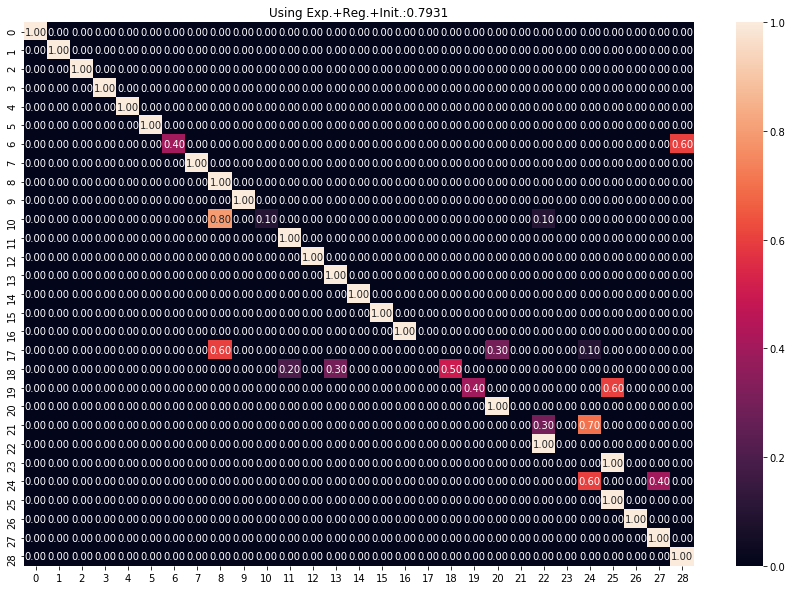

In [30]:
summarize_net(cnn, X_test, ds.y_test, title_text='Using Exp.+Reg.+Init.:')

# Ensemble Nets
Now lets do the exact same thing, but with an average of three separate networks. 

To get this running, we are going to use the keras `Model API` which is different than the `Sequential API`. It requires that we explicitly define the inputs and outputs, and gives us a bit more control over the network topology.

- https://keras.io/models/model/

Reminder of Differences from Sequential and Functional APIs:
- You will need to specify the input and output nodes explicitly.
 - `input_layer = Input(shape=(**insert shape here**))`
- You no longer `add` to a `Sequential`, you feed layer by layer:
 - `model.add(Dense())` becomes `layer2 = Dense()(input_layer)`
 - subsequent layers use temporary variables like `layer1` and `input_layer` above
- Tell the Model what the input and output temporary variables are:
 - `model = Model(inputs=input_layer,outputs=layer1)`
 - then you can call `model.compile()`
- A great example that uses the Model API with MNIST:
 - https://cambridgespark.com/content/tutorials/neural-networks-tuning-techniques/index.html

In [31]:
%%time

from keras.layers import average, concatenate
from keras.models import Input, Model

num_ensembles = 3
l2_lambda = 0.000001

input_holder = Input(shape=(ds.img_size, ds.img_size, 1))

# start with a conv layer
x = Conv2D(filters=32,
               input_shape = (ds.img_size,ds.img_size,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', data_format="channels_last")(input_holder)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu')(x)
input_conv = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

branches = []
for _ in range(num_ensembles):
    
    # start using NiN (MLPConv)
    x = Conv2D(filters=32,
                   input_shape = (ds.img_size,ds.img_size,1),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(input_conv)

    x = Conv2D(filters=32,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
    
    x = Conv2D(filters=64,
                   input_shape = (ds.img_size,ds.img_size,1),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)

    x = Conv2D(filters=64,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    # add one layer on flattened output
    x = Flatten()(x)
    x = Dropout(0.50)(x) # add some dropout for regularization after conv layers
    x = Dense(64, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
            )(x)
    
    x = Dense(NUM_CLASSES, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
             )(x)
    
    # now add this branch onto the master list
    branches.append(x)

# that's it, we just need to average the results
x = concatenate(branches)

x = Dense(NUM_CLASSES, 
          activation='softmax', 
          kernel_initializer='glorot_uniform',
          kernel_regularizer=l2(l2_lambda)
         )(x)

# here is the secret sauce for setting the network using the 
#   Functional API:
cnn_ens = Model(inputs=input_holder,outputs=x)

cnn_ens.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 32, 32, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 32, 32, 32)   9248        conv2d_11[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 16, 16, 32)   0           conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_13 

In [32]:
# Let's train the model 
cnn_ens.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])



In [33]:
# the flow method yields batches of images indefinitely, with the given transofmrations
cnn_ens.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=batch_size), 
                      steps_per_epoch=int(len(X_train)/batch_size), # how many generators to go through per epoch
                      epochs=epochs, verbose=1,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                     )

Epoch 1/15
81/81 [==============================] - 10s 118ms/step - loss: 2.8772 - acc: 0.1647 - val_loss: 2.1618 - val_acc: 0.3069
Epoch 2/15
81/81 [==============================] - 8s 102ms/step - loss: 1.5081 - acc: 0.4940 - val_loss: 1.5004 - val_acc: 0.6345
Epoch 3/15
81/81 [==============================] - 8s 105ms/step - loss: 0.8705 - acc: 0.7098 - val_loss: 1.4842 - val_acc: 0.5345
Epoch 4/15
81/81 [==============================] - 9s 106ms/step - loss: 0.5504 - acc: 0.8154 - val_loss: 1.0190 - val_acc: 0.6828
Epoch 5/15
81/81 [==============================] - 9s 108ms/step - loss: 0.3489 - acc: 0.8797 - val_loss: 1.2320 - val_acc: 0.7034
Epoch 6/15
81/81 [==============================] - 9s 112ms/step - loss: 0.2199 - acc: 0.9302 - val_loss: 0.8499 - val_acc: 0.8034
Epoch 7/15
81/81 [==============================] - 9s 113ms/step - loss: 0.1549 - acc: 0.9495 - val_loss: 1.1928 - val_acc: 0.7655
Epoch 8/15
81/81 [==============================] - 9s 115ms/step - loss: 0

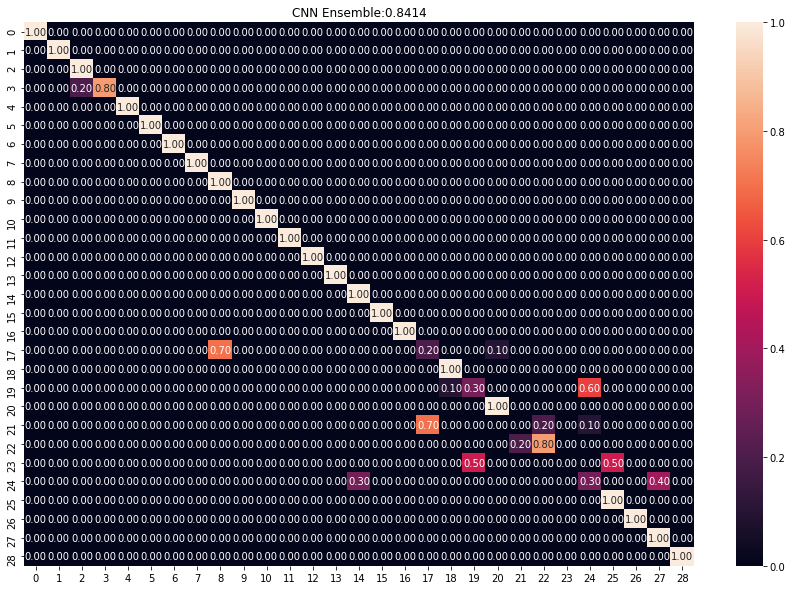

In [34]:
summarize_net(cnn_ens, X_test, ds.y_test, title_text='CNN Ensemble:')

___
# Adding ResNet Style Blocks
Okay, so now lets try a trick from 2016---ancient in terms of deep learning years (that's a joke 🤷, ¯\\_(ツ)_/¯). 

The ResNet-Style Bypass is described in the following:
![resnet](https://cdn-images-1.medium.com/max/1600/0*0r0vS8myiqyOb79L.jpg)

In [35]:
%%time

# now lets use the LeNet architecture with batch norm
# We will also use ReLU where approriate and drop out 
from keras.layers.normalization import BatchNormalization
from keras.layers import Add
from keras.layers import average, concatenate
from keras.models import Input, Model

input_holder = Input(shape=(ds.img_size, ds.img_size, 1))

# start with a conv layer
x = Conv2D(filters=32,
               input_shape = (ds.img_size,ds.img_size,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(input_holder)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=64,
               kernel_size=(1,1),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x_split)

x = Conv2D(filters=64,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(1,1),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

# now add back in the split layer, x_split (residual added in)
x = Add()([x, x_split])
x = Activation("relu")(x)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256)(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES)(x)
x = Activation('softmax')(x)

resnet = Model(inputs=input_holder,outputs=x)

resnet.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 32, 32, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 16, 16, 32)   0           conv2d_25[0][0]                  
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 16, 16, 32)   9248        max_pooling2d_12[0][0]           
__________________________________________________________________________________________________
max_poolin

In [36]:
resnet.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

# the flow method yields batches of images indefinitely, with the given transofmrations
# resnet.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
#                       steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
#                       epochs=50, verbose=1,
#                       validation_data=(X_test,y_test_ohe),
#                       callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
#                      )

resnet.fit(X_train, y_train_ohe, batch_size=batch_size, 
                      epochs=epochs, verbose=1,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                     )

Train on 2610 samples, validate on 290 samples
Epoch 1/15
2610/2610 [==============================] - 3s 1ms/step - loss: 2.8553 - acc: 0.1877 - val_loss: 1.9934 - val_acc: 0.5034
Epoch 2/15
2610/2610 [==============================] - 2s 935us/step - loss: 1.4920 - acc: 0.5261 - val_loss: 1.3197 - val_acc: 0.5931
Epoch 3/15
2610/2610 [==============================] - 2s 915us/step - loss: 0.7965 - acc: 0.7368 - val_loss: 1.1285 - val_acc: 0.6655
Epoch 4/15
2610/2610 [==============================] - 2s 946us/step - loss: 0.4933 - acc: 0.8379 - val_loss: 1.1064 - val_acc: 0.7276
Epoch 5/15
2610/2610 [==============================] - 2s 949us/step - loss: 0.3285 - acc: 0.8935 - val_loss: 1.1300 - val_acc: 0.6931
Epoch 6/15
2610/2610 [==============================] - 3s 962us/step - loss: 0.2646 - acc: 0.9088 - val_loss: 0.8023 - val_acc: 0.7931
Epoch 7/15
2610/2610 [==============================] - 3s 990us/step - loss: 0.1691 - acc: 0.9441 - val_loss: 0.7460 - val_acc: 0.8103
Epo

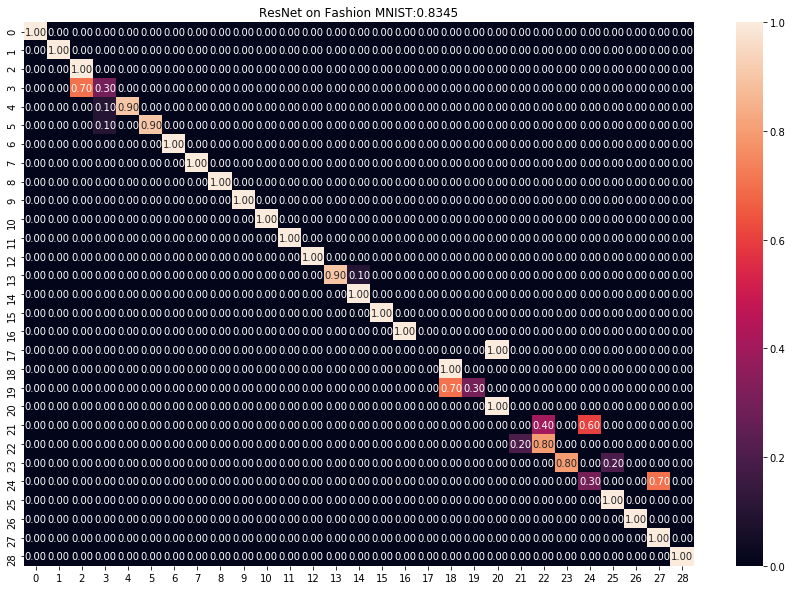

In [38]:
summarize_net(resnet, X_test, ds.y_test, title_text='ResNet on Fashion MNIST:')

In [28]:
# Xception style architecture
from keras.layers import SeparableConv2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Add
from keras.layers import average, concatenate
from keras.models import Input, Model

l2_lambda = 0.000001



input_holder = Input(shape=(ds.img_size, ds.img_size, 1))

# start with a conv layer
x = Conv2D(filters=32,
               input_shape = (ds.img_size,ds.img_size,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(input_holder)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)


x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = SeparableConv2D(filters=32,
               input_shape = (ds.img_size,ds.img_size,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(x_split)


x_split = Add()([x, x_split])

x = SeparableConv2D(filters=32,
               input_shape = (ds.img_size,ds.img_size,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(x_split)


x_split = Add()([x, x_split])


x = Activation("relu")(x_split)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES,activation="softmax")(x)

xception = Model(inputs=input_holder,outputs=x)

xception.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 32, 32, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 16, 16, 32)   0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 16, 16, 32)   9248        max_pooling2d_7[0][0]            
__________________________________________________________________________________________________
max_poolin

In [29]:
# speed up by training by not using augmentation, perhaps there are faster ways??
xception.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

xception.fit(X_train, y_train_ohe, batch_size=batch_size,
            epochs=epochs, verbose=1,
            validation_data=(X_test,y_test_ohe),
            callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
            )

Train on 2610 samples, validate on 290 samples
Epoch 1/15
2610/2610 [==============================] - 3s 1ms/step - loss: 2.8752 - acc: 0.2054 - val_loss: 2.1990 - val_acc: 0.3517
Epoch 2/15
2610/2610 [==============================] - 2s 917us/step - loss: 1.6235 - acc: 0.5054 - val_loss: 1.4697 - val_acc: 0.6207
Epoch 3/15
2610/2610 [==============================] - 2s 870us/step - loss: 0.9429 - acc: 0.6962 - val_loss: 1.1776 - val_acc: 0.6759
Epoch 4/15
2610/2610 [==============================] - 2s 793us/step - loss: 0.6252 - acc: 0.7950 - val_loss: 1.0130 - val_acc: 0.7034
Epoch 5/15
2610/2610 [==============================] - 2s 796us/step - loss: 0.4018 - acc: 0.8747 - val_loss: 1.0240 - val_acc: 0.7034
Epoch 6/15
2610/2610 [==============================] - 2s 781us/step - loss: 0.2926 - acc: 0.9073 - val_loss: 0.8140 - val_acc: 0.7448
Epoch 7/15
2610/2610 [==============================] - 2s 803us/step - loss: 0.2234 - acc: 0.9257 - val_loss: 0.8277 - val_acc: 0.7966
Epo

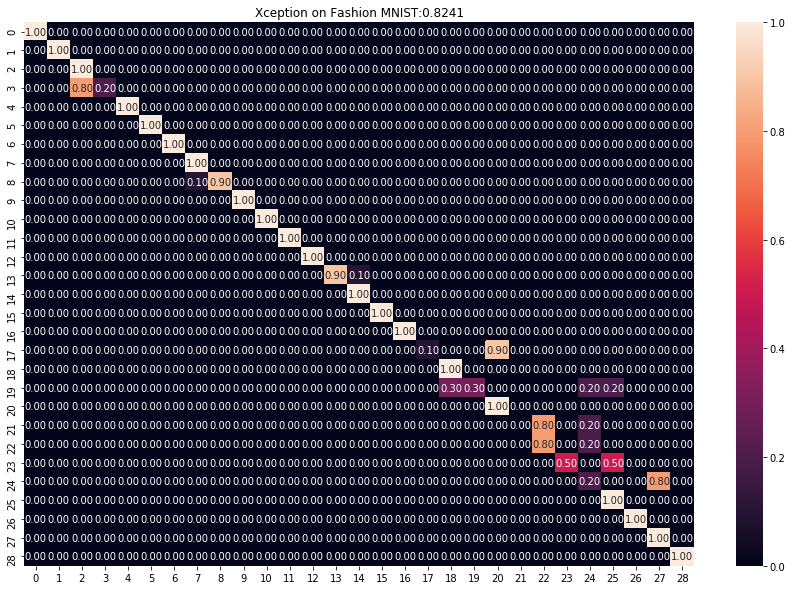

In [30]:
summarize_net(xception, X_test, ds.y_test, title_text='Xception on Fashion MNIST:')

# Using Pre-trained Models
You also have fantastic access to different pre-trained models such as Xception, DenseNet, ResNest, VGG, and many other. For an updated key of available models see:
- https://keras.io/applications/

In [18]:
%%time

# manipulated from Keras Documentation
#  https://keras.io/applications/
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

res_model = ResNet50(weights='imagenet')

CPU times: user 15.2 s, sys: 391 ms, total: 15.6 s
Wall time: 11.5 s


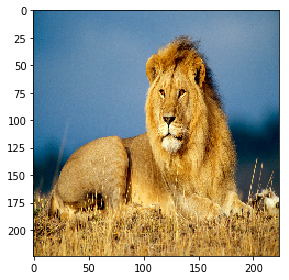

In [19]:
from matplotlib import pyplot as plt
%matplotlib inline
from skimage.io import imshow

def get_image(img_path):
    
    img = image.load_img(img_path, target_size=(224, 224))
    imshow(image.img_to_array(img)/255)
    plt.grid(False)
    return image.img_to_array(img)

img_path = 'data/Simba.jpg'
x = get_image(img_path)

In [20]:
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = res_model.predict(x)
# decode the results into a list of tuples (class, description, probability)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02129165', 'lion', 0.9956579), ('n02130308', 'cheetah', 0.00087044097), ('n07802026', 'hay', 0.00061646913)]


Predicted: [('n04285008', 'sports_car', 0.8644474), ('n03100240', 'convertible', 0.058733054), ('n02974003', 'car_wheel', 0.03669015), ('n03459775', 'grille', 0.024440002), ('n04037443', 'racer', 0.0044455687), ('n03770679', 'minivan', 0.002586552), ('n04483307', 'trimaran', 0.0018270765), ('n02814533', 'beach_wagon', 0.0017102539), ('n04442312', 'toaster', 0.0014616876), ('n02965783', 'car_mirror', 0.00089074747)]


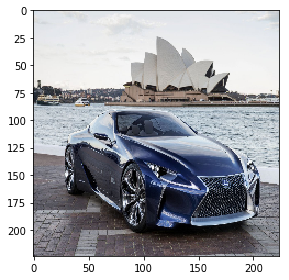

In [21]:
img_path = 'data/MyCar.jpg'
x = get_image(img_path)

x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = res_model.predict(x)
# decode the results into a list of tuples (class, description, probability)
print('Predicted:', decode_predictions(preds, top=10)[0])

_____
_____
**Self Test: Should we do this Live?**

- A. Yes.
- B. No.
- C. It Depends
- D. We're gonna do it anyway

If you have OpenCV installed, you can try this.

**Imposter Syndrome:**

<img src="http://img.memecdn.com/glad-to-know-that-i-amp-039-ve-changed-my-path-years-before_o_7095071.jpg" width=500>


In [39]:
import cv2
import numpy as np
import time
import itertools
%matplotlib inline

from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

if 'res_model' not in locals():
    res_model = ResNet50(weights='imagenet')

ESC_KEY = 27

# setup some windows for viewing
cv2.namedWindow("demowin1")
cv2.startWindowThread()

# open the video card for capture
vc = cv2.VideoCapture(0)

if vc.isOpened():  # try to get the first frame
    print ("vc opened, getting first frame")
    rval, frame = vc.read()
    # this will likely fail the first time
    # the webcam often needs some time to open fully
    key = 0
else:
    print ("vc not open, exiting")
    key = ESC_KEY

while key != ESC_KEY and vc.isOpened():  # the escape key and the capture device is open
    rval, frame = vc.read()
    key = cv2.waitKey(10)

    if rval and frame is not None:
        
        frame_to_show = cv2.pyrDown(frame)  # make smaller immediately
        # grab the ROI in top left (will show later on)
        frame_down = frame_to_show[0:224,0:224]
        
        # increase contrast
        img_yuv = cv2.cvtColor(frame_down, cv2.COLOR_BGR2YUV)
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])# equalize the histogram of the Y channel
        frame_down = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)# convert the YUV image back to RGB format

        # and then remove noise
        frame_down = cv2.fastNlMeansDenoisingColored(frame_down,None,7,7,3,11)
        
        img = frame_down.copy() # make a copy for numpy

        x = image.img_to_array(img[:,:,::-1]) # convert to numpy
        x = np.expand_dims(x, axis=0) # add batch dimension
        x = preprocess_input(x) # apply resnet presets

        preds = res_model.predict(x) # get the predictions
        
        # decode the results into a list of tuples (class, description, probability)
        txt = str(decode_predictions(preds, top=3)[0])

        cv2.putText(frame_to_show, txt, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, [255, 255, 255])
        cv2.rectangle(frame_to_show, (0,0), (224,224), (255,255,255), 1)
        cv2.imshow("demowin1", frame_to_show)
    
print('releasing...')
cv2.waitKey(1)
cv2.destroyAllWindows()
cv2.waitKey(1)
print('Done')

vc opened, getting first frame
releasing...
Done


# Transfer Learning With ResNet

In [1]:
from keras.datasets import cifar10
from keras.utils import to_categorical

NUM_CLASSES = 10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

y_train_ohe = to_categorical(y_train, NUM_CLASSES)
y_test_ohe = to_categorical(y_test, NUM_CLASSES)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

/Users/eclarson/anaconda3/envs/mlenv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [2]:
%%time
# from skimage.transform import resize # stupid slow function
from scipy.misc import imresize
import numpy as np


x_train_up = [imresize(x, size=(64,64,3), interp='nearest') for x in x_train]
x_train_up = np.stack(x_train_up, axis=0)
print(x_train_up.shape)

x_test_up = [imresize(x, size=(64,64,3), interp='nearest') for x in x_test]
x_test_up = np.stack(x_test_up, axis=0)
print(x_test_up.shape)

/Users/eclarson/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


(50000, 64, 64, 3)


/Users/eclarson/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.


(10000, 64, 64, 3)
CPU times: user 7.59 s, sys: 973 ms, total: 8.57 s
Wall time: 8.68 s


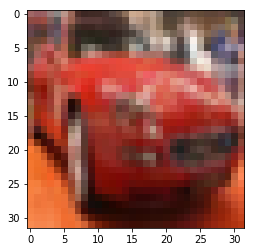

In [38]:
from matplotlib import pyplot as plt
%matplotlib inline
# from skimage.io import imshow
idx = 5
plt.imshow((x_train[idx]-x_train[idx].min())/(x_train[idx].max()-x_train[idx].min()))
plt.grid(False)

In [33]:
x_train_up[0].max()

136.22101

In [3]:
# connect new layers to the output
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions

# load only convolutional layers of resnet:
if 'res_no_top' not in locals():
    res_no_top = ResNet50(weights='imagenet', include_top=False)

x = x_train_up[0]
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

%time preds = res_no_top.predict(x)
preds.shape

/Users/eclarson/anaconda3/envs/mlenv/lib/python3.6/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


CPU times: user 2.88 s, sys: 28.6 ms, total: 2.9 s
Wall time: 1.56 s


(1, 2, 2, 2048)

In [4]:
x_train_up = preprocess_input(x_train_up)
x_test_up = preprocess_input(x_test_up)

In [5]:
%%time

# train on half the data, to save a few hours
x_train_resnet = res_no_top.predict(x_train_up)
x_test_resnet = res_no_top.predict(x_test_up)
print(x_train_resnet.shape)

(50000, 2, 2, 2048)
CPU times: user 1d 4h 52min 22s, sys: 6min 57s, total: 1d 4h 59min 20s
Wall time: 7h 46min 7s


In [6]:
from keras.layers import SeparableConv2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Add, Flatten, Dense
from keras.layers import average, concatenate
from keras.models import Input, Model


# let's add a fully-connected layer
input_x = Input(shape=x_train_resnet[0].shape)
x = Flatten()(input_x)
x = Dense(200, activation='relu',kernel_initializer='he_uniform')(x)
# and a fully connected layer 
predictions = Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform')(x)

model = Model(inputs=input_x, outputs=predictions)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2, 2, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               1638600   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2010      
Total params: 1,640,610
Trainable params: 1,640,610
Non-trainable params: 0
_________________________________________________________________


In [7]:
y_train_ohe_resnet = y_train_ohe[:x_train_resnet.shape[0]]

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

model.fit(x_train_resnet,y_train_ohe_resnet,epochs=5,
          batch_size=64,verbose=1,
         validation_data=(x_test_resnet, y_test_ohe[:x_test_resnet.shape[0]]))

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 232s 5ms/step - loss: 1.0178 - acc: 0.7244 - val_loss: 0.7912 - val_acc: 0.7600
Epoch 2/5
50000/50000 [==============================] - 225s 4ms/step - loss: 0.6051 - acc: 0.8122 - val_loss: 0.7327 - val_acc: 0.7786
Epoch 3/5
50000/50000 [==============================] - 220s 4ms/step - loss: 0.4722 - acc: 0.8522 - val_loss: 0.7996 - val_acc: 0.7807
Epoch 4/5
50000/50000 [==============================] - 221s 4ms/step - loss: 0.3650 - acc: 0.8873 - val_loss: 0.9270 - val_acc: 0.7770
Epoch 5/5
50000/50000 [==============================] - 223s 4ms/step - loss: 0.2813 - acc: 0.9145 - val_loss: 1.1049 - val_acc: 0.7830


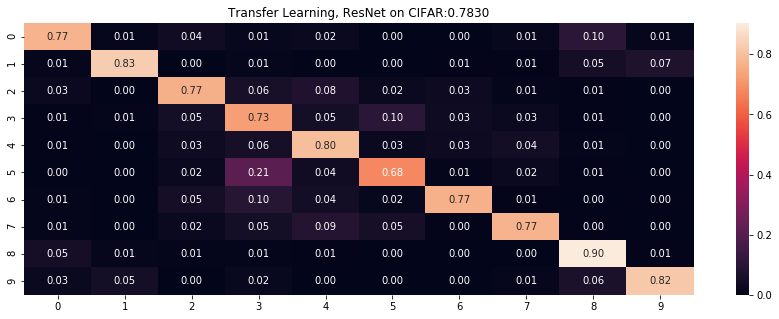

In [10]:
summarize_net(model, x_test_resnet, y_test[:x_test_resnet.shape[0]], title_text='Transfer Learning, ResNet on CIFAR:')

In [11]:
model.fit(x_train_resnet,y_train_ohe_resnet,epochs=5,
          batch_size=64,verbose=1,
         validation_data=(x_test_resnet, y_test_ohe[:x_test_resnet.shape[0]]))

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 252s 5ms/step - loss: 0.2184 - acc: 0.9357 - val_loss: 1.1913 - val_acc: 0.7839
Epoch 2/5
50000/50000 [==============================] - 259s 5ms/step - loss: 0.1689 - acc: 0.9529 - val_loss: 1.3205 - val_acc: 0.7889
Epoch 3/5
50000/50000 [==============================] - 225s 4ms/step - loss: 0.1373 - acc: 0.9625 - val_loss: 1.5595 - val_acc: 0.7811
Epoch 4/5
50000/50000 [==============================] - 226s 5ms/step - loss: 0.1126 - acc: 0.9692 - val_loss: 1.5395 - val_acc: 0.7917
Epoch 5/5
50000/50000 [==============================] - 228s 5ms/step - loss: 0.0891 - acc: 0.9762 - val_loss: 1.6964 - val_acc: 0.7901


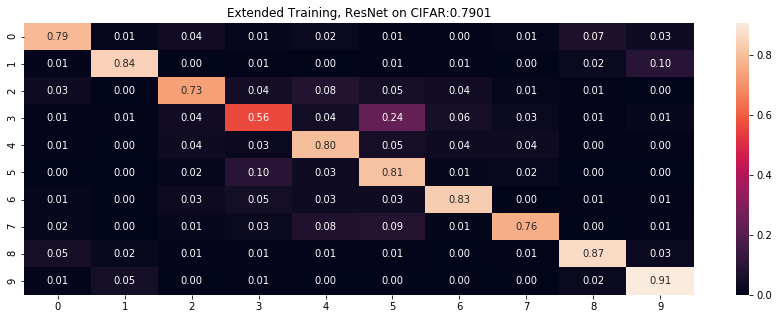

In [12]:
summarize_net(model, x_test_resnet, y_test[:x_test_resnet.shape[0]], title_text='Extended Training, ResNet on CIFAR:')

In [13]:
model.fit(x_train_resnet,y_train_ohe_resnet,epochs=5,
          batch_size=64,verbose=1,
         validation_data=(x_test_resnet, y_test_ohe[:x_test_resnet.shape[0]]))

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 224s 4ms/step - loss: 0.0909 - acc: 0.9782 - val_loss: 1.7258 - val_acc: 0.7903
Epoch 2/5
50000/50000 [==============================] - 226s 5ms/step - loss: 0.0769 - acc: 0.9812 - val_loss: 1.7928 - val_acc: 0.7953
Epoch 3/5
50000/50000 [==============================] - 228s 5ms/step - loss: 0.0651 - acc: 0.9852 - val_loss: 1.9714 - val_acc: 0.7861
Epoch 4/5
50000/50000 [==============================] - 223s 4ms/step - loss: 0.0687 - acc: 0.9849 - val_loss: 1.9146 - val_acc: 0.7958
Epoch 5/5
50000/50000 [==============================] - 237s 5ms/step - loss: 0.0589 - acc: 0.9872 - val_loss: 1.9639 - val_acc: 0.7911
